# Example plotting notebook for RRFS North American Ensemble

## Overview

This Notebook provides a few examples of exploring Grib2 data with XArray, plotting a single field from a variable with multiple vertical levels, and plotting a 9-panel ensemble of Composite Reflectivity using XArray and Matplotlib Python utilities. The option to plot zoomed in pre-defined subdomains also exists.


## Requirements
- Python 3.6+
- XArray
- Matplotlib
- Basemap
- PyNIO
- NumPy
- MetPy


## Input Data

Download Grib2 files to be used with this Notebook from the AWS S3 Bucket here: https://noaa-rrfs-pds.s3.amazonaws.com/index.html



In [1]:
%matplotlib inline

import datetime as dt

from matplotlib import cm
import matplotlib.pyplot as plt
from metpy.plots import ctables
from mpl_toolkits.basemap import Basemap
import numpy as np
import xarray as xr

## Explore a single dataset

XArray uses the PyNIO data engine for loading Grib2 files. Grib2 naming encoding follows the conventions documented here: https://www.pyngl.ucar.edu/NioFormats.shtml#GRIB2-support-details

Running the cell below shows the information associated with the open dataset. Be sure to use the **arrows** on the left side of the output to expand sections, and the **document** and **database** buttons to the right of a variable or coordinate to see metadata and values, respectively.

You can also collapse the whole section to a smaller scrollable box (a feature of the Jupyter Notebook) by clicking the white space just under the `Out[?]` label to the left of the cell.

In [2]:
# Open a single ensemble member and view its contents
data_path = f'/scratch2/BMC/wrfruc/cholt/data/na_3km/20210517/rrfs.t00z.mem01.naf018.grib2'
data_path = f'/scratch2/BMC/wrfruc/cholt/data/na_3km/20210517/rrfs.t00z.mem01.testbed.conusf018.grib2'
dataset = xr.open_dataset(data_path, engine='pynio')
dataset


<xarray.Dataset>
Dimensions:                          (lv_HTGL2: 2, lv_HTGL3: 2, lv_HTGL5: 2, lv_HYBL4: 2, lv_ISBL0: 2, lv_SPDL1: 3, xgrid_0: 1799, ygrid_0: 1059)
Coordinates:
  * lv_HYBL4                         (lv_HYBL4) float32 1.0 2.0
  * lv_HTGL3                         (lv_HTGL3) float32 1000.0 4000.0
  * lv_ISBL0                         (lv_ISBL0) float32 50000.0 70000.0
    gridlat_0                        (ygrid_0, xgrid_0) float32 ...
    gridlon_0                        (ygrid_0, xgrid_0) float32 ...
Dimensions without coordinates: lv_HTGL2, lv_HTGL5, lv_SPDL1, xgrid_0, ygrid_0
Data variables:
    TMP_P0_L103_GLC0                 (ygrid_0, xgrid_0) float32 ...
    TMP_P0_2L108_GLC0                (ygrid_0, xgrid_0) float32 ...
    DPT_P0_L103_GLC0                 (ygrid_0, xgrid_0) float32 ...
    DPT_P0_2L108_GLC0                (ygrid_0, xgrid_0) float32 ...
    RH_P0_L103_GLC0                  (ygrid_0, xgrid_0) float32 ...
    RH_P0_2L108_GLC0                 (ygrid_0, xgrid_0) float32 ...
    PRATE_P0_L1_GLC0                 (ygrid_0, xgrid_0) float32 ...
    SNOD_P0_L1_GLC0                  (ygrid_0, xgrid_0) float32 ...
    WEASD_P0_L1_GLC0                 (ygrid_0, xgrid_0) float32 ...
    CRAIN_P0_L1_GLC0                 (ygrid_0, xgrid_0) float32 ...
    CFRZR_P0_L1_GLC0                 (ygrid_0, xgrid_0) float32 ...
    CICEP_P0_L1_GLC0                 (ygrid_0, xgrid_0) float32 ...
    CSNOW_P0_L1_GLC0                 (ygrid_0, xgrid_0) float32 ...
    UGRD_P0_L100_GLC0                (ygrid_0, xgrid_0) float32 ...
    UGRD_P0_L103_GLC0                (ygrid_0, xgrid_0) float32 ...
    UGRD_P0_2L108_GLC0               (ygrid_0, xgrid_0) float32 ...
    VGRD_P0_L100_GLC0                (ygrid_0, xgrid_0) float32 ...
    VGRD_P0_L103_GLC0                (ygrid_0, xgrid_0) float32 ...
    VGRD_P0_2L108_GLC0               (ygrid_0, xgrid_0) float32 ...
    VVEL_P0_L100_GLC0                (lv_ISBL0, ygrid_0, xgrid_0) float32 ...
    VVEL_P0_2L108_GLC0               (ygrid_0, xgrid_0) float32 ...
    GUST_P0_L1_GLC0                  (ygrid_0, xgrid_0) float32 ...
    PRES_P0_L1_GLC0                  (ygrid_0, xgrid_0) float32 ...
    PRMSL_P0_L101_GLC0               (ygrid_0, xgrid_0) float32 ...
    HGT_P0_L1_GLC0                   (ygrid_0, xgrid_0) float32 ...
    HGT_P0_L100_GLC0                 (ygrid_0, xgrid_0) float32 ...
    MSLET_P0_L101_GLC0               (ygrid_0, xgrid_0) float32 ...
    CAPE_P0_L1_GLC0                  (ygrid_0, xgrid_0) float32 ...
    CAPE_P0_2L108_GLC0               (lv_SPDL1, ygrid_0, xgrid_0) float32 ...
    CIN_P0_L1_GLC0                   (ygrid_0, xgrid_0) float32 ...
    CIN_P0_2L108_GLC0                (lv_SPDL1, ygrid_0, xgrid_0) float32 ...
    HLCY_P0_2L103_GLC0               (lv_HTGL2, ygrid_0, xgrid_0) float32 ...
    4LFTX_P0_2L108_GLC0              (ygrid_0, xgrid_0) float32 ...
    UPHL_P0_2L103_GLC0               (ygrid_0, xgrid_0) float32 ...
    REFD_P0_L20_GLC0                 (ygrid_0, xgrid_0) float32 ...
    REFD_P0_L103_GLC0                (lv_HTGL3, ygrid_0, xgrid_0) float32 ...
    REFD_P0_L105_GLC0                (lv_HYBL4, ygrid_0, xgrid_0) float32 ...
    REFC_P0_L200_GLC0                (ygrid_0, xgrid_0) float32 ...
    CPOFP_P0_L1_GLC0                 (ygrid_0, xgrid_0) float32 ...
    TMAX_P8_L103_GLC0_max1h          (ygrid_0, xgrid_0) float32 ...
    APCP_P8_L1_GLC0_acc18h           (ygrid_0, xgrid_0) float32 ...
    APCP_P8_L1_GLC0_acc1h            (ygrid_0, xgrid_0) float32 ...
    MAXRH_P8_L103_GLC0_max1h         (ygrid_0, xgrid_0) float32 ...
    MINRH_P8_L103_GLC0_min1h         (ygrid_0, xgrid_0) float32 ...
    MAXUVV_P8_2L100_GLC0_max1h       (ygrid_0, xgrid_0) float32 ...
    MAXDVV_P8_2L100_GLC0_max1h       (ygrid_0, xgrid_0) float32 ...
    MAXUW_P8_L103_GLC0_max1h         (ygrid_0, xgrid_0) float32 ...
    MAXVW_P8_L103_GLC0_max1h         (ygrid_0, xgrid_0) float32 ...
    MXUPHL_P8_2L103_GLC0_max1h       (lv_HTGL5, ygrid_0, xgrid_

In [3]:

SUBDOMAINS = {
    'NC': [36, 51, -109, -85],
    'NE': [36, 48, -91, -62],
    'NW': [35, 52, -126, -102],
    'SC': [24, 41, -107, -86],
    'SE': [22, 37, -93.5, -72],
    'SW': [24.5, 45, -122, -103],
    'AKZoom': [52, 73, -162, -132],
    'ATL': [31.2, 35.8, -87.4, -79.8],
    'CA-NV': [30, 45, -124, -114],
    'CentralCA': [34.5, 40.5, -124, -118],
    'CHI-DET': [39, 44, -92, -83],
    'DCArea': [36.7, 40, -81, -72],
    'EastCO': [36.5, 41.5, -108, -101.8],
    'GreatLakes': [37, 50, -96, -70],
    'HI': [16.6, 24.6, -157.6, -157.5],
    'NYC-BOS': [40, 43, -78.5, -68.5],
    'SEA-POR': [43, 50, -125, -119],
    'SouthCA': [31, 37, -120, -114],
    'SouthFL': [24, 28.5, -84, -77],
    'VortexSE': [30, 37, -92.5, -82],
}
    
def cref_colors(levels):

    ''' Default color map for Reflectivity '''

    ncolors = len(levels)-1
    grays = cm.get_cmap('Greys', 5)([0])
    nws = ctables.colortables.get_colortable('NWSReflectivity')(range(ncolors))
    white = cm.get_cmap('Greys', 5)([0])
    return np.concatenate((grays, nws, white))
    
def get_grid_info(ds, subdomain=None):
    
    '''Returns the grid info needed for generating a Basemap of the projected data. '''
    
    lat = ds.get('gridlat_0')
    lon = ds.get('gridlon_0')
    grid_type = grid_suffix(ds)
       
    grid_info = {}
    
    if grid_type == 'GRLL0':
        grid_info['projection'] = 'rotpole'
        lon_0 = lat.attrs.get('CenterLon', lat.attrs.get('Longitude_of_southern_pole'))
        grid_info['lon_0'] = lon_0[0] - 360
    
        center_lat = lat.attrs.get('CenterLat', lat.attrs.get('Latitude_of_southern_pole'))
        grid_info['o_lat_p'] = - center_lat[0] if center_lat[0] < 0 else 90 - center_lat[0]
        
        grid_info['o_lon_p'] = 180
    elif grid_type == 'GLC0':
        
        grid_info['projection'] = 'lcc'
        grid_info['lat_0'] = 39.0
        grid_info['lon_0'] = lat.attrs['Lov']
        grid_info['lat_2'] = lat.attrs['Latin2']
        grid_info['lat_1'] = lat.attrs['Latin1']
        

    if subdomain is None:
        corners = [lat[0, 0], lat[-1, -1], lon[0, 0], lon[-1, -1]]
    else:
        corners = SUBDOMAINS.get(subdomain)
    
    grid_info.update(dict(
        llcrnrlat=corners[0],
        llcrnrlon=corners[2],
        urcrnrlat=corners[1],
        urcrnrlon=corners[3],
        ))

    return grid_info

def grid_suffix(ds):
    ''' Returns the grid suffix of the input dataset '''

    for var in ds.keys():
        vsplit = var.split('_')
        if len(vsplit) == 4:
            return vsplit[-1]
        
def valid_time(data_var):
    
    '''Given an XArray variable from a dataset, return the valid time'''
    
    init_time = dt.datetime.strptime(data_var.initial_time, '%m/%d/%Y (%H:%M)')
    fhr = dt.timedelta(hours=int(data_var.forecast_time[0]))
    valid_time = init_time + fhr
    return dt.datetime.strftime(valid_time, '%Y%m%d %H UTC')



## Plot a field on a map

In [4]:
# The name of variable to plot, and the vertical index of the desired level.
# The example shows 2m Temperature

# Example of 2m Temp 

## Use this section for full domain files
# **************************************************
# **************************************************
# variable = 'TMP_P0_L103_GRLL0'
# vertical_level = 0 # Corresonds to lv_HTGL2 = 2.0


# # Get the values
# data_var = dataset.get(variable)
# values = data_var[vertical_level, :, :]

# **************************************************
# **************************************************


## Use this section for CONUS subdomain files
# **************************************************
# **************************************************
variable = 'TMP_P0_L103_GLC0'

# Get the values
data_var = dataset.get(variable)
values = data_var[:, :]

# **************************************************
# **************************************************

## You should get a map something like this by running the next section

![alt text](2mT_SC_mem1.png "Title")

Text(0.5, 0, 'Valid time: 20210517 18 UTC')

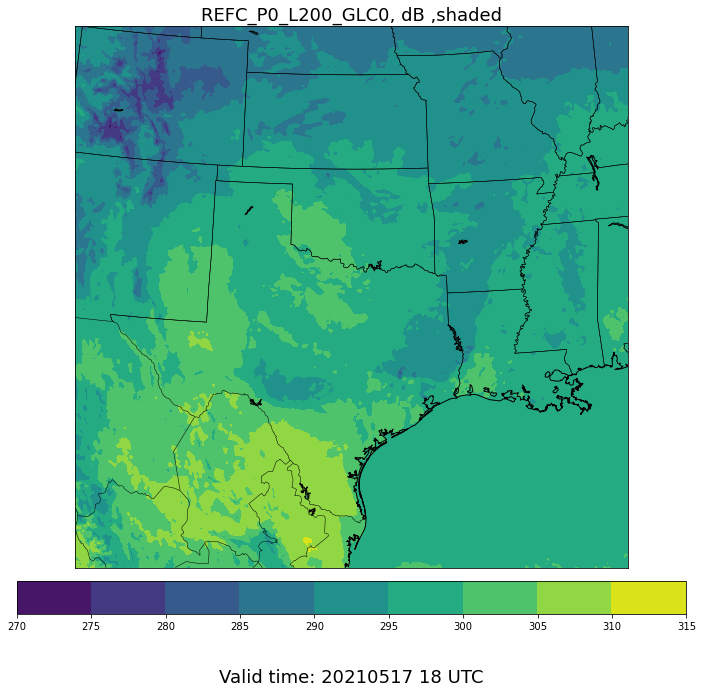

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

subdomain = 'SC' # Choose from any of the keys to SUBDOMAINS dict above and enter it here as a string, or use None

m = Basemap(ax=ax, resolution='i', **get_grid_info(dataset, subdomain))
m.drawcoastlines()
m.drawstates()
m.drawcountries()


lat, lon = [dataset.get(v).values for v in ['gridlat_0', 'gridlon_0']]
adjust = 360 if np.any(lon < 0) else 0
x, y = m(adjust + lon, lat)
cf = m.contourf(x, y, values)

plt.colorbar(cf, ax=ax, orientation='horizontal', pad=0.02, shrink=1.0)

plt.title(f'{variable}, {dataset.get(variable).units} ,shaded', fontsize=18)

plt.xlabel(f"Valid time: {valid_time(data_var)}", fontsize=18, labelpad=100)



# A 9-panel plot of Composite Reflectivity in the SouthEast

In [6]:
# Open all ensemble members at once and view the contents
data_path = f'/scratch2/BMC/wrfruc/cholt/data/na_3km/20210517/rrfs.t00z.mem*.naf018.grib2'
data_path = f'/scratch2/BMC/wrfruc/cholt/data/na_3km/20210517/rrfs.t00z.mem*.testbed.conusf018.grib2'
ensemble = xr.open_mfdataset(data_path, 
                             combine='nested',
                             compat='override',
                             concat_dim='ens',
                             coords='minimal',
                             engine='pynio',
                            )
ensemble


<xarray.Dataset>
Dimensions:                          (ens: 9, lv_HTGL2: 2, lv_HTGL3: 2, lv_HTGL5: 2, lv_HYBL4: 2, lv_ISBL0: 2, lv_SPDL1: 3, xgrid_0: 1799, ygrid_0: 1059)
Coordinates:
    gridlat_0                        (ygrid_0, xgrid_0) float32 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    gridlon_0                        (ygrid_0, xgrid_0) float32 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
  * lv_HTGL3                         (lv_HTGL3) float32 1000.0 4000.0
  * lv_HYBL4                         (lv_HYBL4) float32 1.0 2.0
  * lv_ISBL0                         (lv_ISBL0) float32 50000.0 70000.0
Dimensions without coordinates: ens, lv_HTGL2, lv_HTGL5, lv_SPDL1, xgrid_0, ygrid_0
Data variables:
    TMP_P0_L103_GLC0                 (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    TMP_P0_2L108_GLC0                (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    DPT_P0_L103_GLC0                 (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    DPT_P0_2L108_GLC0                (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    RH_P0_L103_GLC0                  (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    RH_P0_2L108_GLC0                 (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    PRATE_P0_L1_GLC0                 (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    SNOD_P0_L1_GLC0                  (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    WEASD_P0_L1_GLC0                 (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    CRAIN_P0_L1_GLC0                 (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    CFRZR_P0_L1_GLC0                 (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    CICEP_P0_L1_GLC0                 (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    CSNOW_P0_L1_GLC0                 (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    UGRD_P0_L100_GLC0                (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    UGRD_P0_L103_GLC0                (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    UGRD_P0_2L108_GLC0               (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    VGRD_P0_L100_GLC0                (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    VGRD_P0_L103_GLC0                (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    VGRD_P0_2L108_GLC0               (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    VVEL_P0_L100_GLC0                (ens, lv_ISBL0, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 2, 1059, 1799), meta=np.ndarray>
    VVEL_P0_2L108_GLC0               (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    GUST_P0_L1_GLC0                  (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    PRES_P0_L1_GLC0                  (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    PRMSL_P0_L101_GLC0               (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    HGT_P0_L1_GLC0                   (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    HGT_P0_L100_GLC0                 (ens, ygrid_0, xgrid_0) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    MSLET_P0_L101_GLC0               (ens

In [7]:
## Use this section for CONUS subdomain files
# **************************************************
# **************************************************
variable = 'REFC_P0_L200_GLC0'

# Get the values
data_var = ensemble.get(variable)

# **************************************************
# **************************************************

Preparing member 1
Preparing member 2
Preparing member 3
Preparing member 4
Preparing member 5
Preparing member 6
Preparing member 7
Preparing member 8
Preparing member 9


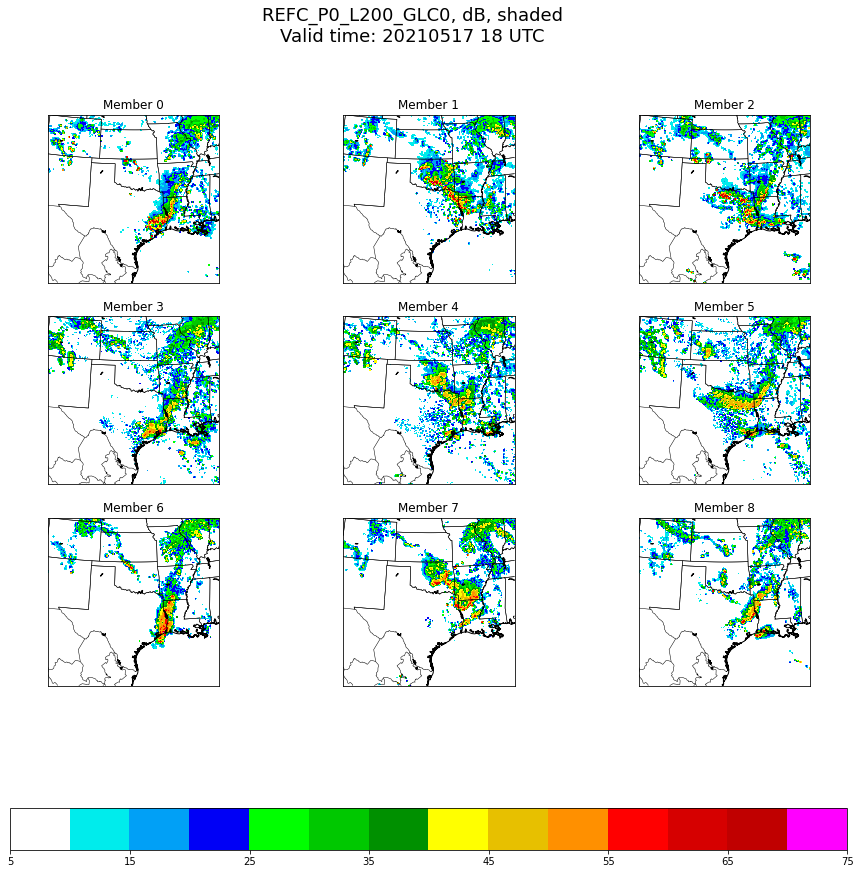

In [12]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

subdomain = 'SC' # Choose from any of the keys to SUBDOMAINS dict above and enter it here as a string, or use None

lat, lon = [ensemble.get(v).values for v in ['gridlat_0', 'gridlon_0']]
adjust = 360 if np.any(lon < 0) else 0

grid_info = get_grid_info(ensemble, subdomain)

nmembers = 9
for member in range(nmembers):
    
    print(f'Preparing member {member+1}')
    # Determine the subplot by row and column
    col = member % 3
    row = member // 3 ## Integer division on purpose!
    s_ax = ax[row, col]
    
    # Draw the map
    m = Basemap(ax=s_ax, resolution='i', **grid_info)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    
    # Add the subplot title
    s_ax.set_title(f'Member {member}')
    
    # Put the data on the map
    x, y = m(adjust + lon, lat)
    levels = np.arange(5, 76, 5)
    cf = m.contourf(x, y, data_var.isel(ens=member), colors=cref_colors(levels), levels=levels)

# Add a single title at the top of the figure
plt.suptitle(f'{variable}, {ensemble.get(variable).units}, shaded \nValid time: {valid_time(data_var)} ', fontsize=18)

# Add a single colorbar at the bottom of the figure
fig.colorbar(cf, ax=ax, orientation='horizontal')


plt.savefig('9mem_refl.png')
